# Training neural network to predict ball position in a 3d space
## 1. Importing Libraries

In [269]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from utils.evaluate import evaluate_model
from utils.plot_maker_gaussian_process import plot_maker_3d

## 2. Importing Data

In [270]:
# get all train data
X_train_circle = pd.read_csv('../data/data-train-circle/red_ball_coordinates_128px_2024-03-05_18h54m.csv', decimal='.', delimiter=',')
X_train_curve = pd.read_csv('../data/data-train-curve/red_ball_coordinates_128px_2024-03-06_19h13m.csv', decimal='.', delimiter=',')
X_train_spiral = pd.read_csv('../data/data-train-spiral/red_ball_coordinates_128px_2024-03-06_18h56m.csv', decimal='.', delimiter=',')
X_train_sin = pd.read_csv('../data/data-train-sin-nick/red_ball_coordinates_128px_2024-03-05_full.csv', decimal='.', delimiter=',')[:600]
X_train_circle.shape, X_train_curve.shape, X_train_spiral.shape, X_train_sin.shape

((646, 14), (799, 14), (618, 14), (600, 14))

In [271]:
# get all the position data
y_train_circle = pd.read_csv('../data/data-train-circle/positions_xyz_2024-03-05_18h54m.csv', decimal='.', delimiter=',')
y_train_curve = pd.read_csv('../data/data-train-curve/positions_xyz_2024-03-06_19h13m.csv', decimal='.', delimiter=',')
y_train_spiral = pd.read_csv('../data/data-train-spiral/positions_xyz_2024-03-06_18h54m.csv', decimal='.', delimiter=',')
y_train_sin = pd.read_csv('../data/data-train-sin-nick/positions_xyz_128px_2024-03-05_full.csv', decimal='.', delimiter=',')[:600]
y_train_circle.shape, y_train_curve.shape, y_train_spiral.shape, y_train_sin.shape

((650, 3), (803, 3), (622, 3), (600, 3))

In [272]:
# remove first 4 rows of the data
y_train_circle = y_train_circle.iloc[4:]
y_train_curve = y_train_curve.iloc[4:]
y_train_spiral = y_train_spiral.iloc[4:]
y_train_circle.shape, y_train_curve.shape, y_train_spiral.shape, y_train_sin.shape

((646, 3), (799, 3), (618, 3), (600, 3))

In [273]:
# concatenate all the data
X_train = pd.concat([X_train_circle, X_train_curve, X_train_spiral, X_train_sin])
y_train = pd.concat([y_train_circle, y_train_curve, y_train_spiral, y_train_sin])
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_train.shape, y_train.shape

((2663, 14), (2663, 3))

## 3. Data Preprocessing

In [274]:
combined = pd.concat([X_train, y_train], axis=1)
combined

,u0,v0,u1,v1,u2,v2,u3,v3,u4,v4,u5,v5,u6,v6,x,y,z
0,61.000000,83.000000,42.000000,92.500000,59.0,75.00,52.000000,75.000000,36.000000,76.000000,42.0,69.500000,44.00,68.5,10.139580,3.359998,22.34200
1,61.000000,83.000000,42.000000,93.000000,59.0,75.00,52.000000,75.000000,36.000000,76.000000,42.0,69.500000,23.50,69.5,10.138330,3.409981,22.39198
2,60.500000,83.000000,42.000000,93.000000,59.0,76.00,52.000000,75.000000,36.000000,77.000000,42.0,69.500000,23.50,69.5,10.136250,3.459938,22.44194
3,61.000000,83.000000,42.000000,93.000000,59.5,76.00,32.000000,75.000000,36.000000,77.000000,42.0,70.000000,23.50,69.5,10.133340,3.509852,22.49185
4,61.000000,83.000000,2.000000,86.000000,60.0,76.00,32.000000,75.000000,36.000000,77.500000,42.0,70.000000,23.50,69.5,10.129590,3.559711,22.54171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2658,39.428571,80.857143,58.166667,55.500000,39.0,112.50,39.333333,88.666667,41.500000,66.500000,59.0,104.000000,83.50,88.5,8.717477,5.861777,24.84378
2659,40.000000,80.857143,62.000000,57.000000,40.0,113.25,39.750000,89.000000,41.666667,66.666667,62.0,105.222222,84.25,89.0,8.631554,5.912934,24.89493
2660,40.000000,80.857143,58.666667,55.833333,40.5,113.50,40.500000,89.500000,42.333333,67.333333,59.5,104.500000,84.50,89.5,8.543978,5.961197,24.94320
2661,40.285714,81.285714,65.000000,58.750000,41.0,113.50,40.500000,89.500000,42.500000,67.500000,64.8,106.300000,85.20,89.4,8.454843,6.006514,24.98851


In [275]:
# check for missing values
print(f'The data has missing values: {combined.isnull().sum().sum()}')
combined.dropna(inplace=True)
combined.shape

The data has missing values: 6


(2660, 17)

In [276]:
X = combined.iloc[:, :14]
y = combined.iloc[:, 14:]

In [277]:
# scale the data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

## 4. Hyperparameter Tuning

In [278]:
# create a pipeline
pipeline = Pipeline([
    ('mlp', MLPRegressor(random_state=42))
])

In [279]:
param_grid = {
    'mlp__hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100,)],
    'mlp__activation': ['identity', 'tanh', 'relu'],
    'mlp__solver': ['sgd', 'adam'],
    'mlp__alpha': [0.001, 0.01, 0.1],
    'mlp__max_iter': [10000, 20000, 28000],
    'mlp__learning_rate': ['constant', 'adaptive'],
    'mlp__learning_rate_init': [0.001, 0.01, 0.1],
    'mlp__early_stopping': [True],
}

random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=5, n_iter=100, n_jobs=-1, verbose=3, random_state=42)

random_search.fit(X_scaled, y_scaled)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\xande\venv\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
48 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\xande\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\xande\venv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\xande\venv\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\xande\venv\lib\site-

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('mlp',
                                              MLPRegressor(random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'mlp__activation': ['identity', 'tanh',
                                                            'relu'],
                                        'mlp__alpha': [0.001, 0.01, 0.1],
                                        'mlp__early_stopping': [True],
                                        'mlp__hidden_layer_sizes': [(50, 50,
                                                                     50),
                                                                    (50, 100,
                                                                     50),
                                                                    (100,)],
                                        'mlp__learning_rate': ['constant',
                                                               'adaptive'],
                                        'mlp__learning_rate_init': [0.001, 0.01,
                                                                    0.1],
                                        'mlp__max_iter': [10000, 20000, 28000],
                                        'mlp__solver': ['sgd', 'adam']},
                   random_state=42, verbose=3)

In [280]:
print(f'Best parameters: {random_search.best_params_}')
print(f'Best score: {random_search.best_score_}')

Best parameters: {'mlp__solver': 'adam', 'mlp__max_iter': 28000, 'mlp__learning_rate_init': 0.01, 'mlp__learning_rate': 'constant', 'mlp__hidden_layer_sizes': (50, 50, 50), 'mlp__early_stopping': True, 'mlp__alpha': 0.01, 'mlp__activation': 'relu'}
Best score: 0.6845767194236668


In [281]:
model = random_search.best_estimator_

## 5. Training the Model

In [282]:
model.fit(X_scaled, y_scaled)

Pipeline(steps=[('mlp',
                 MLPRegressor(alpha=0.01, early_stopping=True,
                              hidden_layer_sizes=(50, 50, 50),
                              learning_rate_init=0.01, max_iter=28000,
                              random_state=42))])

## 6. Make Predictions On Test Data

In [283]:
# get all test data
X_test_circle = pd.read_csv('../data/data-test-circle/red_ball_coordinates_128px_2024-03-05_18h59m.csv', decimal='.', delimiter=',')
X_test_curve = pd.read_csv('../data/data-test-curve/red_ball_coordinates_128px_2024-03-06_19h16m.csv', decimal='.', delimiter=',')
X_test_spiral = pd.read_csv('../data/data-test-spiral/red_ball_coordinates_128px_2024-03-06_18h57m.csv', decimal='.', delimiter=',')
X_test_circle.shape, X_test_curve.shape, X_test_spiral.shape

((299, 14), (308, 14), (387, 14))

In [284]:
# get all the position data
y_test_circle = pd.read_csv('../data/data-test-circle/positions_xyz_2024-03-05_18h59m.csv', decimal='.', delimiter=',')
y_test_curve = pd.read_csv('../data/data-test-curve/positions_xyz_2024-03-06_19h16m.csv', decimal='.', delimiter=',')
y_test_spiral = pd.read_csv('../data/data-test-spiral/positions_xyz_2024-03-06_18h57m.csv', decimal='.', delimiter=',')
y_test_circle.shape, y_test_curve.shape, y_test_spiral.shape

((303, 3), (312, 3), (391, 3))

In [285]:
def prepare_and_scale_test_data(X_test_val, y_test_val, scaler_x_test):
    y_test_val = y_test_val.iloc[4:]
    combined_test = pd.concat([X_test_val, y_test_val], axis=1)
    combined_test.dropna(inplace=True)
    X_val = combined_test.iloc[:, :14]
    y_val = combined_test.iloc[:, 14:]
    X_scaled_test = scaler_x_test.transform(X_val)
    return X_scaled_test, y_val

In [286]:
def predict_evaluate_plot(X_test_val_scaled, y_test_val, nn_model, scaler_y_test, title='Trajectory of Ball in 3D Space'):
    y_test_predicted_scaled = nn_model.predict(X_test_val_scaled)
    y_test_pred = scaler_y_test.inverse_transform(y_test_predicted_scaled)
    mse, mae, r2 = evaluate_model(y_test_val, y_test_pred, 'Test Data')
    # change col 1 and 2 from place, so it corresponds to the unity 3d space
    y_test_pred = y_test_pred[:, [0, 2, 1]]
    y_test_val = y_test_val.to_numpy()[:, [0, 2, 1]]
    plot_maker_3d(y_test_val, y_test_pred, title)
    return y_test_pred, mse, mae, r2

Mean Squared Error on Test Data Set: 0.7503214614497491
Mean Absolute Error on Test Data Set: 0.5688260061232503
R2 Score on Test Data set: 0.8163968260705774


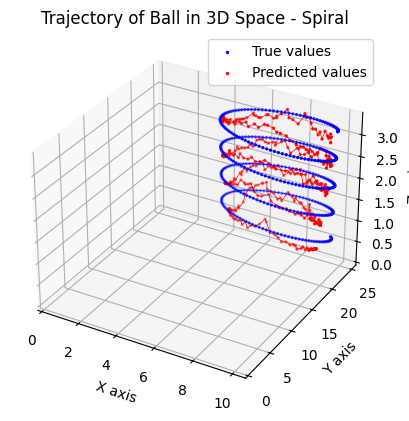

In [287]:
X_test_scaled_spiral, y_test_spiral = prepare_and_scale_test_data(X_test_spiral, y_test_spiral, scaler_x)
y_test_pred_spiral, mse_spiral, mae_spiral, r2_spiral =predict_evaluate_plot(X_test_scaled_spiral, y_test_spiral, model, scaler_y, 'Trajectory of Ball in 3D Space - Spiral')

Mean Squared Error on Test Data Set: 0.26796701438877596
Mean Absolute Error on Test Data Set: 0.36221308279824704
R2 Score on Test Data set: 0.8599918888672026


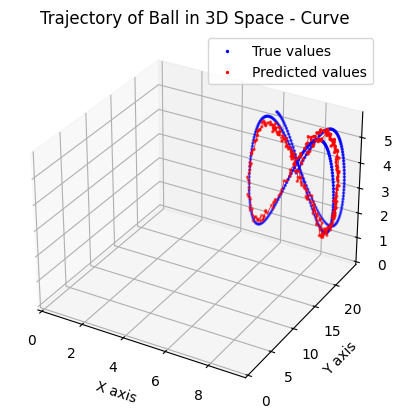

In [288]:
X_test_scaled_curve, y_test_curve = prepare_and_scale_test_data(X_test_curve, y_test_curve, scaler_x)
y_test_pred_curve, mse_curve, mae_curve, r2_curve = predict_evaluate_plot(X_test_scaled_curve, y_test_curve, model, scaler_y, 'Trajectory of Ball in 3D Space - Curve')

Mean Squared Error on Test Data Set: 2.0107692330569424
Mean Absolute Error on Test Data Set: 1.1155468670671858
R2 Score on Test Data set: 0.7432113527896708


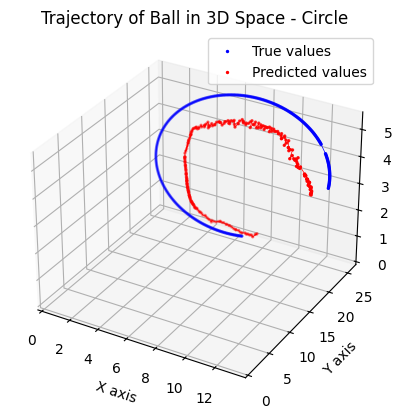

In [289]:
X_test_scaled_circle, y_test_circle = prepare_and_scale_test_data(X_test_circle, y_test_circle, scaler_x)
y_test_pred_circle, mse_cirlce, mae_circle, r2_circle = predict_evaluate_plot(X_test_scaled_circle, y_test_circle, model, scaler_y, 'Trajectory of Ball in 3D Space - Circle')

In [290]:
# put the results in df
results = pd.DataFrame({
    'mse': [mse_cirlce, mse_curve, mse_spiral],
    'mae': [mae_circle, mae_curve, mae_spiral],
    'r2': [r2_circle, r2_curve, r2_spiral]
}, index=['circle', 'curve', 'spiral'])
results

,mse,mae,r2
circle,2.010769,1.115547,0.743211
curve,0.267967,0.362213,0.859992
spiral,0.750321,0.568826,0.816397
